## Equations

We consider the Poisson equation:

$$
\begin{equation}
\nabla\cdot(\nabla T) + Q_T = 0 \quad \text{in }\Omega
\end{equation}$$
w.r.t Dirichlet-type boundary conditions
$$
T(x) = 0 \quad \text{on }\Gamma_D
$$

where $T$ could be temperature, the subscripts $D$ denotes the Dirichlet-type
boundary conditions.
Here, the temperature distribution under the impact of a
line shaped source term should be studied.

## Problem Specifications and Analytical Solution

In OGS there are several benchmarks for line source terms in 2d and 3d domains
available.
Here, some of the 3d benchmarks are described.

### Cylindrical domain

The Poisson equation on cylindrical domain of height $1$ and radius
$r=1$ is solved.
In the following figure the geometry, partly semi-transparent,
is sketched.
Furthermore, the mesh resolution is shown in the cylindrical domain
within the first quadrant of the coordinate system.
In the second quadrant the simulated temperature distribution is depicted.

In [ ]:
# Plot the cylindrical domain with pyvista

import numpy as np
import pyvista as pv
pv.set_plot_theme("document")
pv.set_jupyter_backend("static")

mesh = pv.read("49k_prisms/Cylinder_r_1_h_1_prism_49k.vtu")
plotter = pv.Plotter()

# Create a dict for colorbar arguments
sargs = dict(title = "Temperature", height=0.05, width=0.3, position_x=0.6, position_y=0.05)

# Plot transparent part of mesh
# Create clipping box
clip_box0 = pv.Box([-1, 1, 0, 1, 0, 1])
# Apply the clip filter to the mesh
transparent_mesh = mesh.clip_box(clip_box0)
# Add mesh to the plotter
plotter.add_mesh(transparent_mesh, show_edges=False, opacity = 0.5, cmap="coolwarm", scalar_bar_args=sargs)

# Plot Solid part of mesh
clip_box = pv.Box([-1, 1, -1, 0, 0, 1])
solid_mesh = mesh.clip_box(clip_box)
plotter.add_mesh(solid_mesh, show_edges=False, cmap="coolwarm", opacity = 1, scalar_bar_args=sargs)

# Plot grid lines in one quarter of cylinder
clip_box1 = pv.Box([-1, 1, -1, 0, 0, 1])
partial_mesh1 = mesh.clip_box(clip_box1)
clip_box2 = pv.Box([-1, 0, -1, 1, 0, 1])
partial_mesh2 = partial_mesh1.clip_box(clip_box2)
plotter.add_mesh(partial_mesh2, show_edges=True, edge_color="mediumblue", cmap="coolwarm", scalar_bar_args=sargs)

# Plot line 
start_point = [-1, 0, 0.5]
end_point = [1, 0, 0.5]
line = pv.Line(start_point, end_point)
plotter.add_mesh(line, show_edges=True, color = "white", line_width = 5)

# Set the camera's field of view
camera = plotter.camera
plotter.camera.focal_point = (0, 0, 0.5)  # Set the focal point (where the camera is looking)
plotter.camera.position = (-3, -4.5, 3.5)  # Set the camera position (-2, -3, 2.5) *0.5 = (-1, -1.5, 1.25)

plotter.show_grid()
plotter.add_axes()
plotter.window_size = [1500,1000]
plotter.show()

The source term is defined along the line in the center of the cylinder:
$$
\begin{equation}
Q(x) = 1 \quad \text{at } x=0, y=0.
\end{equation}
$$

In the above figure the source term is the red vertical line in the origin of the coordinate system.

The analytical solution for a line source in the cylinder is.

$$
\begin{equation}
T(x) = - \frac{1}{2 \pi} \ln \sqrt{x^2 + y^2}.
\end{equation}
$$

In [1]:
# Define analytical solution
def t_analytical(x, y):
    return -(1 / (2 * np.pi)) * np.log(np.sqrt(x**2 + y**2))

### Analytical solution in ParaView

Since the analytical solution has a singularity at $(x, y) = (0, 0)$ the
analytical solution in ParaView is generated as follows:

```none
if (coordsX^2<0.0001 & coordsY^2<0.0001, temperature, -1/(4*asin(1))*ln(sqrt(coordsX^2+coordsY^2)))
```

## Numerical simulation 286k mesh

The applied mesh has a resolution of 286k cells.

In [2]:
# Create output path if it doesn't exist yet
import os

out_dir = os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out")

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [ ]:
# Import OGS class
from ogs6py.ogs import OGS

model = OGS(PROJECT_FILE="286k_prisms/line_source_term_in_cylinder.prj")
model.run_model(logfile=f"{out_dir}/286k_out.txt", args=f"-o {out_dir} -m 286k_prisms")

## Results and evaluation

The following plot shows the temperature along the white line in the figure above.

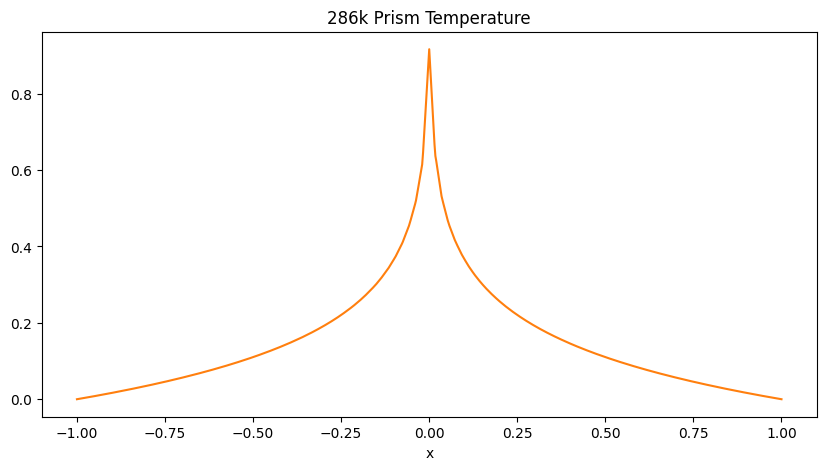

In [3]:
import os
import vtuIO
import numpy as np
import matplotlib.pyplot as plt

# Extract values along a line in the domain

# Load results
pvdfile_286k = vtuIO.PVDIO(f"{out_dir}/3D_line_source_term_in_cylinder_286k.pvd", dim=3)

# Get point field names
fields = pvdfile_286k.get_point_field_names()

# Extract values along line
number_of_subdivisions = 801
length = np.linspace(-1, 1, number_of_subdivisions)

# Draws a line through the domain for sampling results
z_axis = [(i, 0, 0.5) for i in length]

# Extract timestep
timestep = 1
temp_286k = pvdfile_286k.read_set_data(timestep, "temperature", pointsetarray=z_axis)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharey=True)
ax.plot(length, temp_286k, label="286k prism", color="tab:orange")
ax.set_title("286k Prism Temperature")
ax.set_xlabel("x")

plt.show()

### Comparison with analytical solution

The differences of analytical and computed solution are small outside of the center.

(array([397, 398, 399, 400, 401, 402, 403]),)


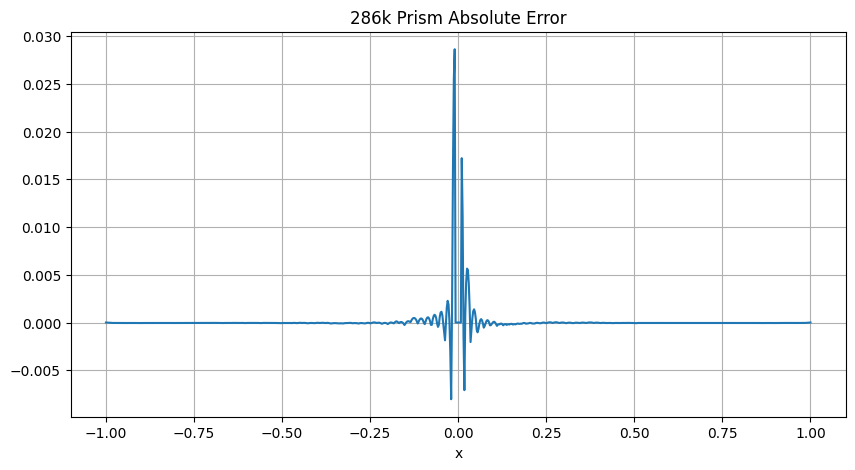

In [4]:
# Combine analytical solution with numerical solution at singularity in (x,y)=(0,0)

# Create reference for error calculation

# Replace 0 with 1 to prevent division by 0, the respective element will be replaced with the numerical solution anyway
length_replaced = length.copy()
length_replaced[int((number_of_subdivisions-1)/2)] = 1


# Replace diverging analytical solution in respective interval below a threshold of 0.01
threshold = 0.01
below_threshold = np.where(np.abs(length) < threshold)
analytical286 = t_analytical(length_replaced, 0)
analytical286[below_threshold[0][0]:(below_threshold[0][-1]+1)] = temp_286k[below_threshold[0][0]:(below_threshold[0][-1]+1)]

# Plot absolute error
fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharey=True)
abs_error286 = temp_286k - analytical286
ax.plot(length, abs_error286)
ax.grid(True)
ax.set_title("286k Prism Absolute Error")
ax.set_xlabel("x")

plt.show()

Due to the numerical evaluation of the relative error of the computed solution the error grows in the vicinity of the boundary and in the center.

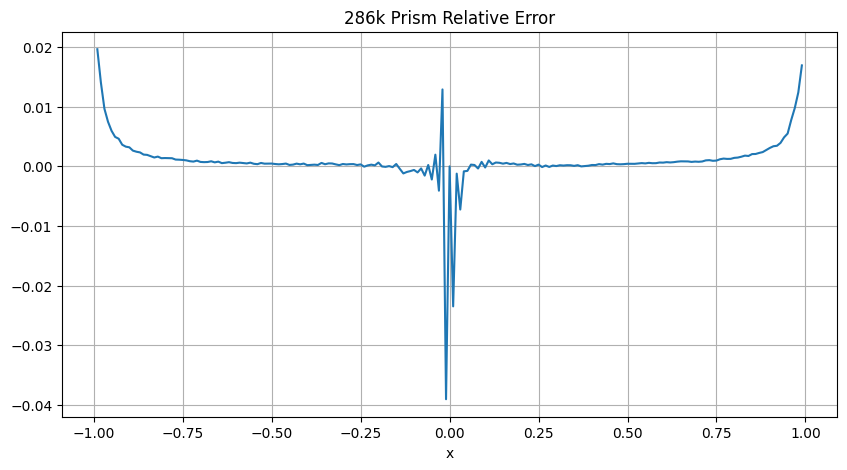

In [5]:
# Relative error
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
rel_error286 = (analytical286[1:-1] - temp_286k[1:-1]) / analytical286[1:-1]
ax.plot(length[1:-1], rel_error286)
ax.grid(True)
ax.set_title("286k Prism Relative Error")
ax.set_xlabel("x")

plt.show()

### Input files

The project files for the described model is [286k.prj](https://gitlab.opengeosys.org/ogs/ogs/-/blob/master/Tests/Data/Parabolic/T/3D_line_source_term_tests/3D_line_source_term_in_cylinder/286k_prisms/line_source_term_in_cylinder.prj).
The project file describes the processes to be solved and the related process variables together with their initial and boundary conditions as well as the source terms.

The input mesh is stored in the VTK file format and can be directly visualized in ParaView for example.

### Cylindrical domain - axisymmetric example

The Poisson equation on cylindrical domain of height $1$ and radius $r=1$ is solved.
The cylindrical domain is defined as axisymmetric.

#### Numerical simulation

In [ ]:
model = OGS(
    PROJECT_FILE="../3D_line_source_term_in_cylinder_axisymmetric/line_source_term_in_cylinder.prj"
)
model.run_model(
    logfile=f"{out_dir}/axisym_out.txt",
    args=f"-o {out_dir} -m ../3D_line_source_term_in_cylinder_axisymmetric",
)

#### Results and evaluation

In [ ]:
# Plot cylinder cross-section

# Load mesh and plot it
mesh = pv.read("../3D_line_source_term_in_cylinder_axisymmetric/square_1x1_quad_100x100.vtu")
plotter = pv.Plotter()
sargs = dict(title = "Temperature", height=0.05, width=0.4, position_x=0.3, position_y=0.05)
plotter.add_mesh(mesh, show_edges=False, cmap="coolwarm", scalar_bar_args=sargs)

# Plot line 
start_point = [0, 0.5, 0]
end_point = [1, 0.5, 0]
line = pv.Line(start_point, end_point)
plotter.add_mesh(line, show_edges=True, color = "white", line_width = 1)

plotter.add_axes()
plotter.show_bounds(mesh, ticks = "both")
plotter.window_size = [1500, 1000]
plotter.view_xy()

# Add text annotations for axis labels
plotter.add_text("X", position=(1100, 140, 0), font_size=16, color="k")
plotter.add_text("Y", position=(400, 850, 0), font_size=16, color="k")
plotter.show()

The above figure shows the computed temperature distribution.

The following plot shows the temperature along the white line in the figure above.

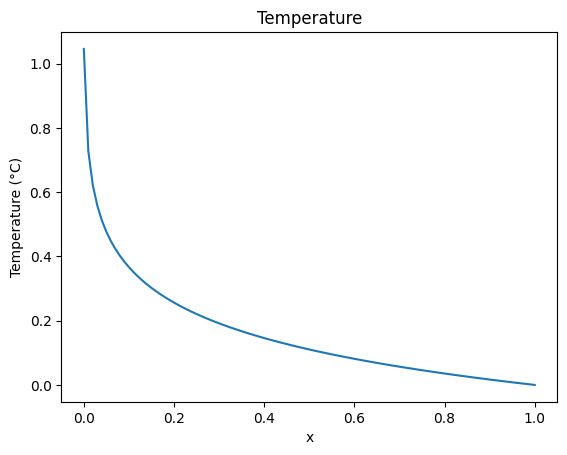

In [14]:
pvdfile_ax = vtuIO.PVDIO(f"{out_dir}/3D_line_source_term_in_cylinder.pvd", dim=3)

# Extract values along line
# Space axis for plotting
length = np.linspace(0, 1, 101)

# Draws a line through the domain for sampling results
z_axis = [(i, 0.5, 0) for i in length]

timestep = 1
temp_ax = pvdfile_ax.read_set_data(timestep, "temperature", pointsetarray=z_axis)


plt.plot(length, temp_ax)
plt.title("Temperature")
plt.xlabel("x")
plt.ylabel("Temperature (°C)")
plt.show()

The error and relative error shows the same behaviour like in the simulation models above.
Outside of the center, that has a singularity in the analytical solution, the errors decreases very fast.

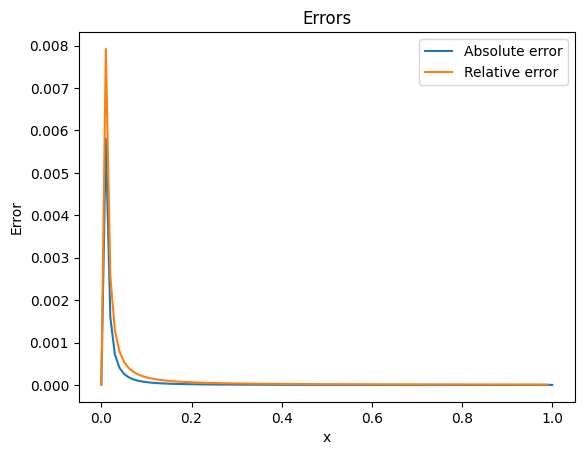

In [15]:
# Create the reference temperature and combine analytical solution with numerical solution at singularity in (x,y)=(0,0)
t_ref = t_analytical(length[1:], 0)
t_ref = np.insert(t_ref, 0, temp_ax[0])

plt.plot(length, t_ref - temp_ax, label="Absolute error")
plt.plot(length[:-1], (t_ref[:-1] - temp_ax[:-1]) / t_ref[:-1], label="Relative error")
plt.title("Errors")
plt.ylabel("Error")
plt.xlabel("x")
plt.legend()
plt.show()

### Input files

The project file for the described model is
[line_source_term_in_cylinder.prj](https://gitlab.opengeosys.org/ogs/ogs/-/blob/master/Tests/Data/Parabolic/T/3D_line_source_term_tests/3D_line_source_term_in_cylinder_axisymmetric/line_source_term_in_cylinder.prj).